In [37]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((301997.266 -4082816.606, 302016.825 ...  -36.867678  -36.870725   

    bbox_east   bbox_west   place_id osm_type    osm_id        lat  \
0  174.779537  174.778569  118523389      way  48383821 -36.869262   

          lon                                       display_name    class  \
0  174.778972  Newmarket, D'urville Heights, Newmarket, Auckl...  railway   

      type  importance  
0  station    0.460255  


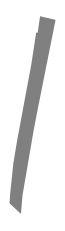

In [3]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("NewMarket, Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [4]:
gdf = ox.geometries.geometries_from_point((-36.8679152, 174.7774390),tags={'amenity':True,'shop':True},dist=3000)
gdf.drop(['addr:housenumber', 'addr:street',
          'phone','website',
          'wheelchair','addr:city',
          'payment:coins','brand',
          'brand:wikidata',
          'brand:wikipedia',
          'cuisine',
          'building',
          'parking',
          'takeaway',
          'healthcare',
          'operator','operator:wikidata','operator:wikipedia',
          'addr:postcode','opening_hours','opening_hours','addr:suburb','email','internet_access',
          'ref:linz:address_id','second_hand','access','fee','bicycle_parking','capacity','covered','nodes',
          'height','supervised','building:levels','layer','operator:type','payment:app','payment:credit_cards'
         ], axis=1, inplace=True)
projected_gdf = ox.project_gdf(gdf)

poi_node_df_columns = ['amenity', 'name', 'geometry',  'shop', 'clothes']
poi_node_df = pd.DataFrame(columns=poi_node_df_columns)

for df_index in projected_gdf.index.values:
    index_type = df_index[0]
    osm_node_id = df_index[1]
    if index_type=="way":
        continue
    row = projected_gdf.loc[df_index]
    poi_node_df = pd.concat([poi_node_df,pd.DataFrame([row],
                                            columns=poi_node_df_columns,
                                            index=[osm_node_id])])
projected_poi_node_df = gpd.geodataframe.DataFrame(poi_node_df)
print(projected_poi_node_df.head())

              amenity                    name  \
61076248          pub           The Clare Inn   
61076379  post_office  Dominion Road Postshop   
61076387     post_box                     NaN   
61078264     pharmacy                     NaN   
61083388          pub    The Edinburgh Castle   

                                                geometry shop clothes  
61076248  POINT (299538.44056521775 -4083610.0755387805)  NaN     NaN  
61076379  POINT (299433.15739684354 -4083941.8669472393)  NaN     NaN  
61076387   POINT (299336.05180713796 -4083565.323587939)  NaN     NaN  
61078264     POINT (299582.488984023 -4083692.899444273)  NaN     NaN  
61083388   POINT (300389.4340456167 -4082112.8279437367)  NaN     NaN  


In [5]:
highway_G = ox.graph_from_point(
    (-36.8679152, 174.7774390),
    dist=3000,
    dist_type="network",
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)
projected_highway_G = ox.project_graph(highway_G)
print(projected_highway_G)

MultiDiGraph with 8951 nodes and 18866 edges


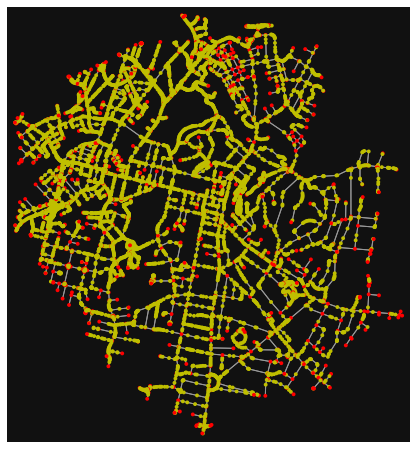

In [6]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(projected_highway_G, node) else "y" for node in projected_highway_G.nodes()]
fig, ax = ox.plot_graph(projected_highway_G, node_color=nc)

In [38]:
geo_x_list = []
geo_y_list = []
for row in projected_poi_node_df.iterrows():
    node_id, node_detail = row[0], row[1]
    coord = node_detail["geometry"]
    if type(coord) == Polygon or type(coord) == MultiPolygon:
        coord = coord.centroid.xy
        x,y= coord[0][0],coord[1][0]
    else:
        x,y =  coord.x,coord.y
    #print(x,y)
    geo_x_list.append(x)
    geo_y_list.append(y)
projected_poi_node_df["x"] = geo_x_list
projected_poi_node_df["y"] = geo_y_list

In [57]:
# 给POI node找到最近的路段，取出该POI node的Amenity类型 或者shop 类型
# 把node id，poi类型，边的node pair 存进一个DF
def find_edge_for_node(road_G,poi_df):
    columns = ["source","target","distance_to_edge",'amenity', 'name', 'geometry', 'shop', 'clothes','x','y']
    output_df = pd.DataFrame(columns=columns)
    road_nodes = road_G.nodes(data=True)

    poi_df_indexes = poi_df.index.values
    nearest_edges = ox.distance.nearest_edges(road_G, poi_df["x"],poi_df["y"],return_dist=False)

    for i in range(len(poi_df)):
        node_id = poi_df_indexes[i]
        node_detail = poi_df.iloc[i]
        x,y = node_detail["x"],node_detail["y"]
        u,v = nearest_edges[i][0],nearest_edges[i][1]
        distance_to_road_start = ox.distance.euclidean_dist_vec(y,x,
                                                              road_nodes[u]["y"],road_nodes[u]["x"])
        distance_to_road_end = ox.distance.euclidean_dist_vec(y,x,
                                                            road_nodes[v]["y"],road_nodes[v]["x"])
        average_distance_to_poi = (distance_to_road_start+ distance_to_road_end)/2

        #print(distance_to_road_start,distance_to_road_end,average_distance_to_poi)
        mapping_row = [u,v,average_distance_to_poi]
        mapping_row= mapping_row+list(node_detail.to_dict().values())
        output_df = pd.concat([output_df,pd.DataFrame([mapping_row],
                                            columns=columns,
                                            index=[node_id])])
    return output_df

In [58]:
poi_mapping_df = find_edge_for_node(projected_highway_G,projected_poi_node_df)
print(poi_mapping_df.head(5))

              source      target  distance_to_edge      amenity  \
61076248  1416725907    32611686        232.830483          pub   
61076379  3128529680    25977860        557.340138  post_office   
61076387  1010508882  6410810191        367.534768     post_box   
61078264  1416725907    32611686        240.814771     pharmacy   
61083388  6235638712  9422236243         16.125100          pub   

                            name  \
61076248           The Clare Inn   
61076379  Dominion Road Postshop   
61076387                     NaN   
61078264                     NaN   
61083388    The Edinburgh Castle   

                                                geometry shop clothes  \
61076248  POINT (299538.44056521775 -4083610.0755387805)  NaN     NaN   
61076379  POINT (299433.15739684354 -4083941.8669472393)  NaN     NaN   
61076387   POINT (299336.05180713796 -4083565.323587939)  NaN     NaN   
61078264     POINT (299582.488984023 -4083692.899444273)  NaN     NaN   
61083388   POIN

In [9]:
#把street转成了node，并且加入了周围POI的type当作feature
def construct_street_nodes(highway_graph,poi_mapping_df):
    columns = ["source","target",'street_name','street_length']
    street_node_output_df = pd.DataFrame(columns=columns)

    for edge in highway_graph.edges(data=True):
        u,v,data = edge
        if data['reversed'] or "name" not in data.keys():
            continue
        #print(data)
        street_id,street_name,street_length = data["osmid"],data["name"],\
                                                       data["length"]
        mapping_row = [u,v,street_name,street_length]
        current_street_node_df = pd.DataFrame([mapping_row],
                                              columns=columns,
                                              index=[street_id])
        #print(u,v)
        matched_source = poi_mapping_df[poi_mapping_df["source"]==u]
        matched_poi_df = matched_source[matched_source["target"]==v]
        # drop unneed columns
        #matched_poi_df= matched_poi_df.drop(labels=["source","target","name"],axis=1)

        number_of_pois = len(matched_poi_df)
        poi_to_edge_total_distance = 0.0
        # Go through poi_df and added up the poi on edge node
        for poi_data in matched_poi_df.iterrows():
            for key,value in poi_data[1].to_dict().items():
                # if key in ["source","target","name"]:
                #     print(street_name,key,value)
                # 把POI到节点的距离先加起来
                if key == "distance_to_edge":
                    poi_to_edge_total_distance += value
                    #print("dist" ,value)
                    continue
                if value is None or str(value)=="nan" or key == "geometry" or key in ["source","target","name"]:
                    continue

                if key == "shop" or key =="clothes":
                    combined_key = key
                elif value =="restaurant" or value =="cafe" or value =="pub" or value =="ice_cream" or value =="bar" or value == "food_court":
                    combined_key = "restaurant"
                elif value =="university" or value == "school":
                    combined_key = "school"
                elif value == "pharmacy" or value == "clinic" or value =="hospital":
                    combined_key = "healthcare"
                    #print(poi_data)
                else:
                    combined_key = key

                if combined_key not in current_street_node_df.columns:
                    current_street_node_df[combined_key] =0
                current_street_node_df[combined_key] +=1
        # 获得POI到街的平均距离
        if number_of_pois > 0:
            poi_to_edge_average_distance = poi_to_edge_total_distance / number_of_pois
            current_street_node_df["Average_POI_Distance"] = poi_to_edge_average_distance
        street_node_output_df = pd.concat([street_node_output_df,current_street_node_df])
    return street_node_output_df



In [10]:
street_node_df=construct_street_nodes(projected_highway_G,poi_mapping_df)
#print(street_node_df.sort_values("street_name")["street_length"])
#print(street_node_df.sort_values("street_name")["Average_POI_Distance"])
street_node_df["Average_POI_Distance"]=street_node_df["Average_POI_Distance"].fillna(street_node_df["street_length"])
street_node_df=street_node_df.fillna(0)
street_node_df.reset_index(inplace=True)
street_node_df = street_node_df.rename(columns = {'index':'street_id'})
print(street_node_df)

       street_id      source      target         street_name  street_length  \
0      624129112    25769228  3797573321  Upper Queen Street         17.509   
1      731599981    25769228  3068087649   Alex Evans Street         13.369   
2      123998327  4961470807    25769228  Upper Queen Street          9.938   
3      624129112  3797573321   265813402  Upper Queen Street          7.678   
4      624129114  2978330161    25769228  Ian McKinnon Drive         19.979   
...          ...         ...         ...                 ...            ...   
8237   624524241  9979530860  9979530859        Tamaki Drive         24.345   
8238   624524241  9979530861  9979530860        Tamaki Drive         32.305   
8239  1090626655  9989527605  9989527608        Greys Avenue          8.463   
8240  1090626655  9989527606  9989527605        Greys Avenue          6.511   
8241     4282801  9989671920  9989671921      Whitaker Place          4.825   

      amenity  Average_POI_Distance  shop  restaura

In [40]:
def construct_street_edges(nodes_df):
    result_dict = {}
    for data in nodes_df.iterrows():
        street_index,node = data[0],data[1]
        u,v = node['source'],node['target']
        result_dict=find_neighbour_streets(street_index,node,nodes_df,u,v,result_dict)
        result_dict=find_neighbour_streets(street_index,node,nodes_df,v,u,result_dict)
        #print(u,v)
        #print(edge_dict)
        #break
    return result_dict

def find_neighbour_streets(node_index,node_data,nodes_df, source,target, edge_dict):
        same_source_neighbours_df = nodes_df[nodes_df["source"]==source]
        same_source_neighbours_df = same_source_neighbours_df[same_source_neighbours_df["target"]!=target]

        same_target_neighbours_df = nodes_df[nodes_df["target"]==source]
        same_target_neighbours_df = same_target_neighbours_df[same_target_neighbours_df["source"]!=target]

        # if street_index == 2298:
        #     print(same_source_neighbours_df)
        #     print(same_target_neighbours_df)
        # Loop through neighbours with same source
        for neighbour_data in same_source_neighbours_df.iterrows():
            neighbour_index,neighbour = neighbour_data[0],neighbour_data[1]
            # nodes within same street can not have same source or target
            edge_key = (node_index,neighbour_index)
            reverse_edge_key=(neighbour_index,node_index)
            edge_distance =  node_data['Average_POI_Distance'] + neighbour['Average_POI_Distance']

            if edge_key in edge_dict:
                if edge_dict[edge_key]!=edge_distance:
                    raise Exception("Multiple Edge Distances with same source")
                continue

            edge_dict[edge_key] = edge_distance
            edge_dict[reverse_edge_key] = edge_distance

        # Loop through neighbours with same target
        for neighbour_data in same_target_neighbours_df.iterrows():
            neighbour_index,neighbour = neighbour_data[0],neighbour_data[1]
            # nodes within same street can not have same source or target
            edge_key = (node_index,neighbour_index)
            reverse_edge_key=(neighbour_index,node_index)
            edge_distance =  node_data['Average_POI_Distance'] + neighbour['Average_POI_Distance']

            if edge_key in edge_dict:
                if edge_dict[edge_key]!=edge_distance:
                    raise Exception("Multiple Edge Distances with same source")
                continue

            edge_dict[edge_key] = edge_distance
            edge_dict[reverse_edge_key] = edge_distance
        return edge_dict

In [41]:
edge_dict = construct_street_edges(street_node_df)
edge_df = pd.DataFrame(columns=["source_street","target_street","distance"])
for k,v in edge_dict.items():
    row = pd.DataFrame([[k[0],k[1],v]],columns=["source_street","target_street","distance"])
    #print(row)
    edge_df = pd.concat([edge_df,row])
edge_df.to_csv("./outputs/nm_street_edges.csv",index=False)
print(edge_df)

   source_street target_street   distance
0              0             1  30.878000
0              1             0  30.878000
0              0             2  27.447000
0              2             0  27.447000
0              0             4  37.488000
..           ...           ...        ...
0           8236          8235  26.309844
0           8237          8238  56.650000
0           8238          8237  56.650000
0           8239          8240  14.974000
0           8240          8239  14.974000

[19614 rows x 3 columns]


In [17]:
street_node_mapping_df = street_node_df.copy(deep=True)
#street_node_mapping_df = street_node_mapping_df[street_node_mapping_df.columns[:4]]
street_node_mapping_df.to_csv("./outputs/nm_street_nodes_mapping.csv",index=False)
print(street_node_mapping_df)

       street_id      source      target         street_name  street_length  \
0      624129112    25769228  3797573321  Upper Queen Street         17.509   
1      731599981    25769228  3068087649   Alex Evans Street         13.369   
2      123998327  4961470807    25769228  Upper Queen Street          9.938   
3      624129112  3797573321   265813402  Upper Queen Street          7.678   
4      624129114  2978330161    25769228  Ian McKinnon Drive         19.979   
...          ...         ...         ...                 ...            ...   
8237   624524241  9979530860  9979530859        Tamaki Drive         24.345   
8238   624524241  9979530861  9979530860        Tamaki Drive         32.305   
8239  1090626655  9989527605  9989527608        Greys Avenue          8.463   
8240  1090626655  9989527606  9989527605        Greys Avenue          6.511   
8241     4282801  9989671920  9989671921      Whitaker Place          4.825   

      amenity  Average_POI_Distance  shop  restaura

In [18]:
street_nodes_final_df = street_node_df.copy(deep=True)
#street_nodes_final_df = street_nodes_final_df[street_nodes_final_df.columns[4:]]
#street_nodes_final_df.drop(["street_length","Average_POI_Distance"],axis=1 ,inplace=True)
print(street_nodes_final_df)
street_nodes_final_df.to_csv("./outputs/nm_street_nodes.csv",index=False)

       street_id      source      target         street_name  street_length  \
0      624129112    25769228  3797573321  Upper Queen Street         17.509   
1      731599981    25769228  3068087649   Alex Evans Street         13.369   
2      123998327  4961470807    25769228  Upper Queen Street          9.938   
3      624129112  3797573321   265813402  Upper Queen Street          7.678   
4      624129114  2978330161    25769228  Ian McKinnon Drive         19.979   
...          ...         ...         ...                 ...            ...   
8237   624524241  9979530860  9979530859        Tamaki Drive         24.345   
8238   624524241  9979530861  9979530860        Tamaki Drive         32.305   
8239  1090626655  9989527605  9989527608        Greys Avenue          8.463   
8240  1090626655  9989527606  9989527605        Greys Avenue          6.511   
8241     4282801  9989671920  9989671921      Whitaker Place          4.825   

      amenity  Average_POI_Distance  shop  restaura